In [2]:
import numpy as np

In [3]:
a = np.array([[1,1], [4,1], [10, 2.5], [3,3], [5,3], [1,4], [3,5]])
a = a[np.argsort(a[:, 1])]

In [4]:
def FNB(x, y, arr, r):
    eps = 1e-8
    minn = 1e+9
    pos = -1
    for i in range(len(arr)):
        if arr[i][1] > y + 2 * r - eps:
            break
        elif arr[i][1] > y - 2 * r + eps:
            if minn - eps > arr[i][0] > x + eps:
                minn = arr[i][0]
                pos = i
    return pos

In [5]:
def CCB(x1, y1, x2, y2, r):
    x_new = -(((2 * r) ** 2 - (y1 - y2) ** 2) ** (1 / 2)) + x2
    l_pr = x_new - x1
    return [x_new, l_pr]

In [6]:
def MOB_x(ind_sh, arr, r, l_ost, l_box):
    # Прежде всего, необходимо понять, находится ли шар в буферной зоне или нет.
    eps = 1e-8
    x = arr[ind_sh][0]
    y = arr[ind_sh][1]

    if x < l_box - r - eps:
        # Мы находимся внутри коробки.
        pos = FNB(x, y, arr, r)

        if pos == -1:
            # Значит шаров, с которыми можно столкнуться внутри коробки нет.
            if l_ost > (l_box - r) - x + eps:
                l_ost -= (l_box - r) - x
                arr[ind_sh][0] = l_box - r
                return MOB_x(ind_sh, arr, r, l_ost, l_box)
            else:
                arr[ind_sh][0] += l_ost
                return arr

        else:
            # Значит есть шар, с которым можно столкнуться.
            x_new, l_pr = CCB(x, y, arr[pos][0], arr[pos][1], r)
            if l_ost > l_pr + eps:
                l_ost -= l_pr
                arr[ind_sh][0] += l_pr
                return MOB_x(pos, arr, r, l_ost, l_box)
            else:
                arr[ind_sh][0] += l_ost
                return arr

    else:
        # Мы находимся внутри буферной зоны или на ее границе.
        # Важным уточнением является то, что мы ввели буферную зону, но не заполняли ее. Поэтому важна отдельная обработка поиска шаров для начала коробки, так как в начальный момент, например, в буфере ничего нет, но вот в начале шар может быть, это необходимо учитывать.
        pos_buf = FNB(x, y, arr, r)
        pos_strt = FNB(x - l_box, y, arr, r)

        # Для начала проверим, есть ли шары, с которыми мы можем столкнуться в буферной зоне.
        if pos_buf != -1:
            # Таким образом, есть шар, с которым мы столкнемся в буферной зоне.
            pos = pos_buf
            x_new, l_pr = CCB(x, y, arr[pos][0], arr[pos][1], r)
            if l_ost > l_pr + eps:
                l_ost -= l_pr
                arr[ind_sh][0] += l_pr
                return MOB_x(pos, arr, r, l_ost, l_box)
            else:
                arr[ind_sh][0] += l_ost
                return arr

        else:
            # То есть буферная полоса пустая. По крайней мере, если "смотреть" с конца, давайте рассмотрим ситуацию от левого края коробки (левой буферной зоны).
            if pos_strt != -1 and np.array_equal(arr[pos_strt], np.array(x, y)) == False:
                # Значит мы нашли шар, с которым мы столкнемся, причем он лежит внутри коробки, иначе мы бы нашли его при просмотре буферной зоны.
                # Здесь необходимо работать аккуратно и, в случае если шар прошел буферную зону перевести его в обычную зону.
                pos = pos_strt
                x_new, l_pr = CCB(x - l_box, y, arr[pos][0], arr[pos][1], r)
                if l_ost > l_pr + eps:
                    l_ost -= l_pr
                    arr[ind_sh][0] += l_pr
                    if arr[ind_sh][0] > (l_box + r) - eps:
                        arr[ind_sh][0] -= (l_box + r)
                    return MOB_x(pos, arr, r, l_ost, l_box)
                else:
                    arr[ind_sh][0] += l_ost
                    if arr[ind_sh][0] > (l_box + r) - eps:
                        arr[ind_sh][0] -= (l_box + r)
                    return arr

            else:
                # Значит шаров для столкновения, тогда двигаем настолько, насколько можем.
                arr[ind_sh][0] += l_ost
                if arr[ind_sh][0] >= (l_box + r) - eps:
                    arr[ind_sh][0] -= (l_box + r)
                return arr

In [117]:
a = np.array([[1,1], [4,1], [10, 2.5], [3,3], [5,3], [1,4], [3,5]])
a = a[np.argsort(a[:, 1])]
shx = 0
shy = 1

a_res_x = MOB_x(shx, a, 1, 7, 11)
copy_x = a_res_x.copy()
for i in range(len(a_res_x)):
    a_res_x[i] = np.array([a_res_x[i][1], a_res_x[i][0]])
a_res_x = a_res_x[np.argsort(a_res_x[:, 1])]


a_res_xy = MOB_x(shy, a_res_x, 1, 5, 11)
for i in range(len(a_res_xy)):
    a_res_xy[i] = np.array([a_res_xy[i][1], a_res_xy[i][0]])

a_res_x = copy_x

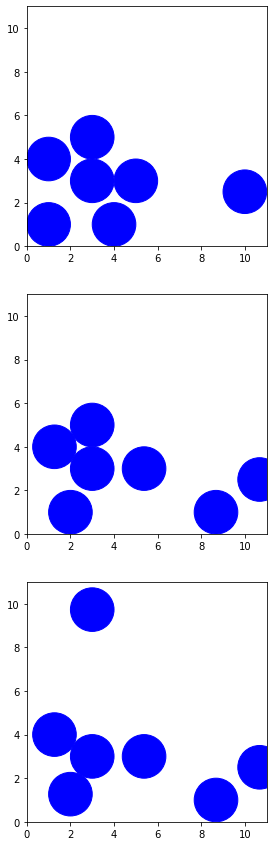

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline
l_box = 11
r = 1
a = np.array([[1,1], [4,1], [10, 2.5], [3,3], [5,3], [1,4], [3,5]])
a = a[np.argsort(a[:, 1])]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15,15))

ax1.set(xlim=(0, l_box), ylim=(0, l_box))
for i in range(len(a)):
    circle = plt.Circle((a[i][0] % l_box, a[i][1] % l_box), r, color='b')
    ax1.add_patch(circle)
ax1.set_aspect('equal')

ax2.set(xlim=(0, l_box), ylim=(0, l_box))
for i in range(len(a_res_x)):
    circle = plt.Circle((a_res_x[i][0] % l_box, a_res_x[i][1] % l_box), r, color='b')
    ax2.add_patch(circle)
ax2.set_aspect('equal')

ax3.set(xlim=(0, l_box), ylim=(0, l_box))
for i in range(len(a_res_xy)):
    circle = plt.Circle((a_res_xy[i][0] % l_box, a_res_xy[i][1] % l_box), r, color='b')
    ax3.add_patch(circle)
ax3.set_aspect('equal')